In [1]:
# %load_ext tensorboard
import datetime
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import seaborn as sn
import pandas as pd

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6894556483304601579
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12260419273575367447
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1397718631
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9257064495794678585
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12133399943416637695
physical_device_desc: "device: XLA_GPU device"
]


In [36]:
IMAGE_SIZE = 160
BATCH_SIZE = 32

IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [37]:
TRAINING_DIR = "dataset"
VALIDATION_DIR = "dataset_kue"
datagen = ImageDataGenerator(
#     rescale = 1./255. ,
    # rotation_range=40,
    # featurewise_center=True,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.4,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.05,
      )

print("Loading training data...\t\t", end='')
train_generator = datagen.flow_from_directory(
	  TRAINING_DIR,
  	target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',

)

print("Loading validation data...\t\t", end='')
validation_generator = datagen.flow_from_directory(
  	TRAINING_DIR,
#     VALIDATION_DIR,
	  target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
)



Loading training data...		Found 623 images belonging to 6 classes.
Loading validation data...		Found 29 images belonging to 6 classes.


In [38]:
TEST_DIR = "dataset_kue_test_2"

test_generator = ImageDataGenerator(
#     rescale = 1./255. ,
)
print("Loading testing data...\t\t", end='')
test_data = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

# image = tf.keras.preprocessing.image.load_img(TEST_DIR)
# test_arr = keras.preprocessing.image.img_to_array(image)
# test_arr = np.array([input_arr])

Loading testing data...		Found 45 images belonging to 6 classes.


In [4]:
class_names = []
for a in train_generator.class_indices:
    class_names.append(a)
print(class_names)

['kue_cenil', 'kue_clorot', 'kue_dadar_gulung', 'kue_lapis', 'kue_mendut', 'kue_serabi']


In [19]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 160, 160, 3), (32, 6))

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'kue_cenil': 0, 'kue_clorot': 1, 'kue_dadar_gulung': 2, 'kue_lapis': 3, 'kue_mendut': 4, 'kue_serabi': 5}


In [20]:
base_model = tf.keras.applications.MobileNetV2(
    IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False
# base_model.summary()

In [40]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


prediction_layer = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')


In [47]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# l_rate = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_4 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_4 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7686

In [48]:
# %tensorboard --logdir logs

# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# history = data_prep.fit(train_generator,
#                     steps_per_epoch=len(train_generator), 
# #                     steps_per_epoch=100, 
#                     epochs=10, 
#                     validation_data = validation_generator, 
#                     validation_steps=len(validation_generator),
# #                     validation_steps=100,
# #                     batch_size=32,
#                     # verbose=1,
#                     # callbacks=[es_callback],
# #                     callbacks=[cm_callback],
#                     )

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data = validation_generator, 
                    validation_steps=len(validation_generator),
                    # verbose=1,
                    # callbacks=[es_callback],
#                     callbacks=[cm_callback],
                    )

Epoch 1/10
20/20 [==============================] - 5s 241ms/step - loss: 0.1806 - accuracy: 0.9438 - val_loss: 0.2205 - val_accuracy: 0.8966
Epoch 2/10
20/20 [==============================] - 4s 197ms/step - loss: 0.1024 - accuracy: 0.9775 - val_loss: 0.1821 - val_accuracy: 0.8966
Epoch 3/10
20/20 [==============================] - 4s 197ms/step - loss: 0.0789 - accuracy: 0.9823 - val_loss: 0.1636 - val_accuracy: 0.9310
Epoch 4/10
20/20 [==============================] - 4s 193ms/step - loss: 0.0597 - accuracy: 0.9936 - val_loss: 0.1407 - val_accuracy: 0.9655
Epoch 5/10
20/20 [==============================] - 4s 190ms/step - loss: 0.0475 - accuracy: 0.9936 - val_loss: 0.1608 - val_accuracy: 0.9310
Epoch 6/10
20/20 [==============================] - 4s 198ms/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.1826 - val_accuracy: 0.8966
Epoch 7/10
20/20 [==============================] - 4s 194ms/step - loss: 0.0355 - accuracy: 0.9968 - val_loss: 0.1434 - val_accuracy: 0.9310
Epoch 

In [46]:
# base_model.trainable= True
for layers in base_model.layers[:-1]:
# for layers in base_model.layers[:-6]:
    layers.trainable = False

# non_t_layers = [-2, -4]
# for n_layer in non_t_layers:
#     base_model.layers[n_layer].trainable = False

# for layers in base_model.layers[-11:]:
#   print(layers)
#   print(layers.trainable)
data_prep.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])


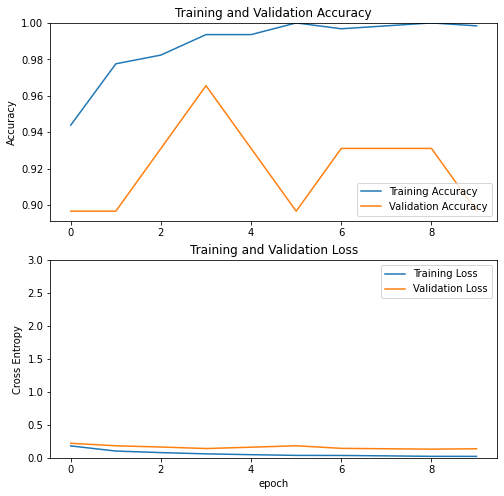

In [49]:
# Before fine tunning

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [50]:
print("Model evaluate:")
results = model.evaluate(test_data)

Model evaluate:
2/2 [==============================] - 0s 73ms/step - loss: 0.2685 - accuracy: 0.8889


In [51]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(validation_generator, 64 // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
conn = confusion_matrix(validation_generator.classes, y_pred)
# print('Confusion Matrix')
# print(conn)

<AxesSubplot:>

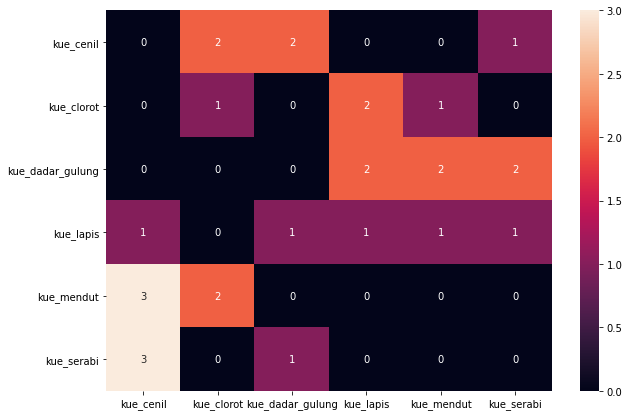

In [52]:
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

IndexError: index 61 is out of bounds for axis 0 with size 61

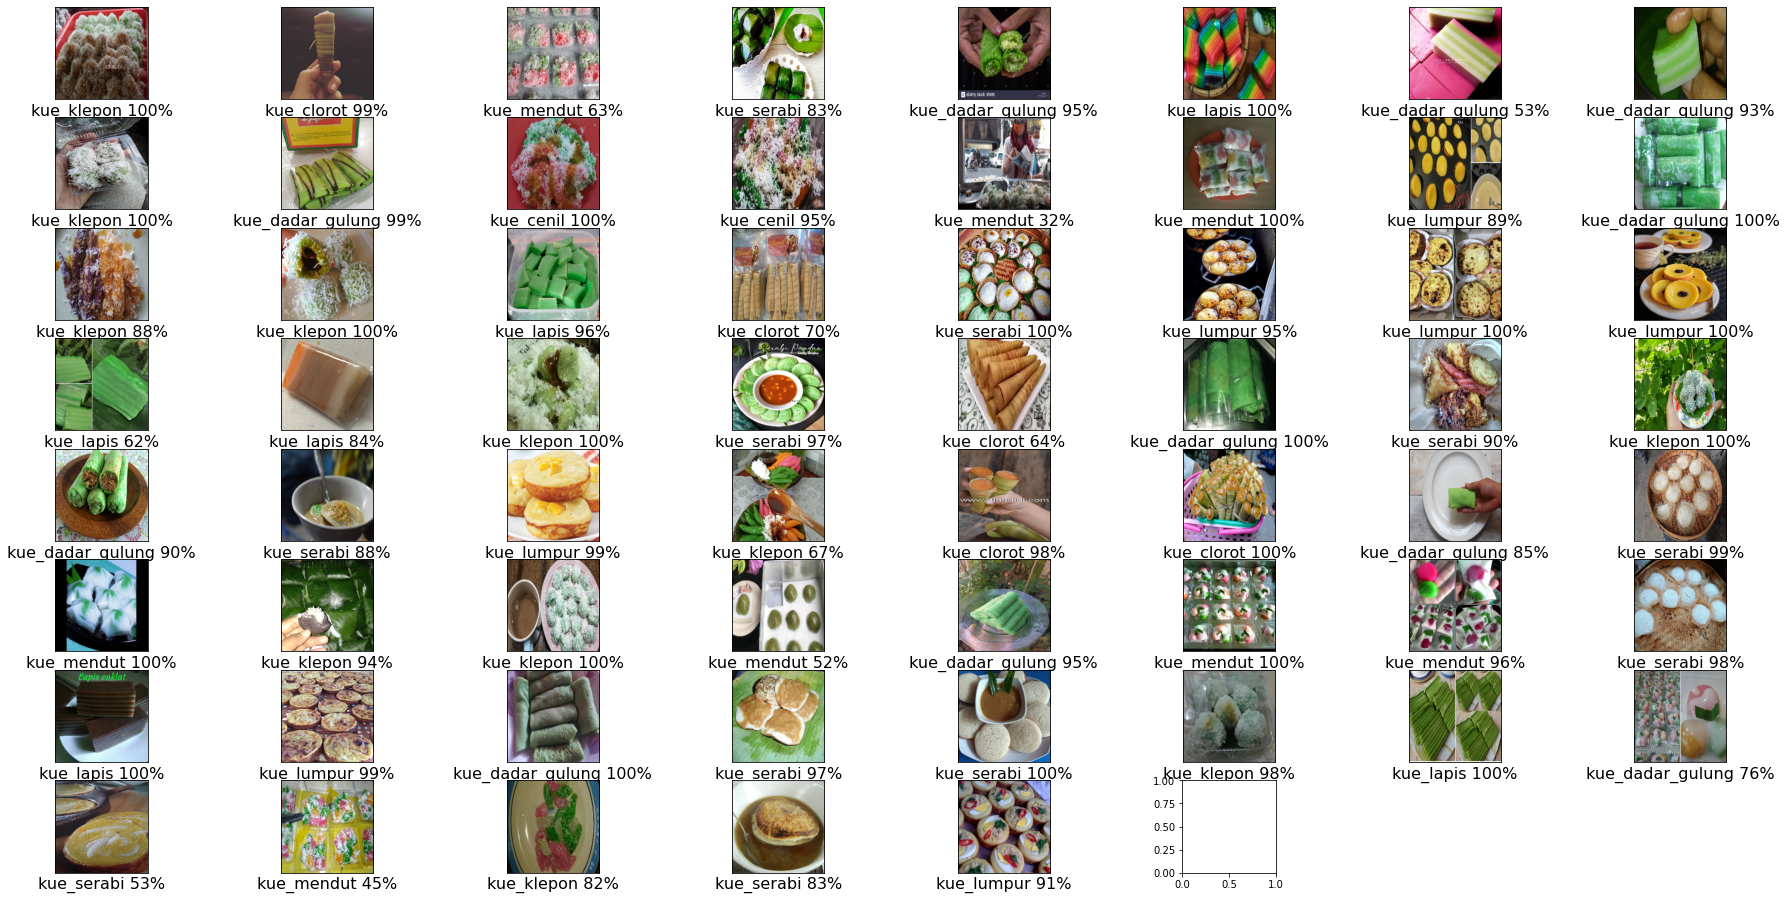

In [16]:
num_rows = 10
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
# class_names = ['kue_cenil', 'kue_clorot', 'kue_mendut', 'dadar gulung', 'klepon', 'lapis', 'lumpur', 'serabi']


def plot_image(i, predictions_array, true_label, img, target):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  predicted_label = np.argmax(predictions_array)

#   if npa[np.array(0)] != target:
#     return
#   if predicted_label == target:
#         if npa[np.array(0)] == target:
#             return

#   print(predicted_label)
#   print(npa[np.array(0)])

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                ),
             fontsize=16,
             )

target = 7
x, y = test_data.next()
for i in range(64):
  predictions = data_prep.predict(x)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y, x, target)

plt.tight_layout()
plt.show()


In [ ]:
saved_model_dir = 'model_final'
tf.saved_model.save(data_prep, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
def show_image(i, true_label, img, target=0):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{}".format(class_names[npa[0]],
                                ),
             fontsize=16,
             )

num_rows = 10
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

x, y = train_generator.next()
for i in range(64):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  show_image(i, y, x)

plt.tight_layout()
plt.show()


In [ ]:
data_prep = tf.keras.Sequential([
#     tf.keras.Input(shape=IMAGE_SHAPE),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=IMAGE_SHAPE),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#   tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
#     tf.keras.layers.experimental.preprocessing.RandomContrast(0.2, input_shape=IMAGE_SHAPE),
    base_model, 
    tf.keras.layers.GlobalMaxPooling2D(),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(1280, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax'),
])

# data_prep.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])
data_prep.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

data_prep.summary()